Cargando librerías
   frame_idx       O_D.x       O_D.y       O_I.x       O_I.y     Nariz.x  \
0         25  396.907142  142.331609  359.406562  140.728690  318.393127   
1         26  393.656866  139.118009  360.293985  138.571558  336.926819   
2         27  390.562597  135.699512  360.847836  136.034588  339.688828   

      Nariz.y      Lomo.x      Lomo.y      Base.x  ...  MA(Nariz.x)  \
0  133.334057  360.771667  110.395309  372.412247  ...          NaN   
1  119.135434  360.720093  110.386368  359.759664  ...          NaN   
2  107.118519  360.722198  110.385910  359.759664  ...          NaN   

   MA(Nariz.y)  MA(Lomo.x)  MA(Lomo.y)  MA(Base.x)  MA(Base.y)  MA(Frente.x)  \
0          NaN         NaN         NaN         NaN         NaN           NaN   
1          NaN         NaN         NaN         NaN         NaN           NaN   
2          NaN         NaN         NaN         NaN         NaN           NaN   

   MA(Frente.y)  MA(Cabeza.x)  MA(Cabeza.y)  
0           NaN         

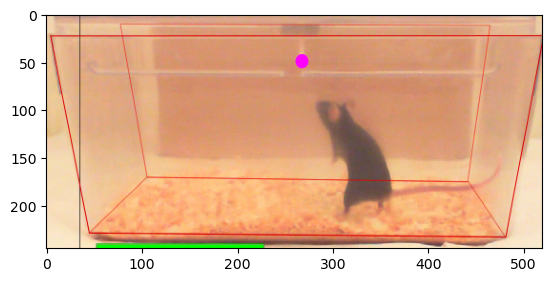

In [10]:
print('Cargando librerías')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

# Cargar el archivo CSV
file_path = 'interpolados.xls'
df = pd.read_excel(file_path, header=[0], sheet_name='B4' )


df.head(6)

background = 'DLC inference/video.png'

orig_img = cv2.cvtColor(cv2.imread(background), cv2.COLOR_BGR2RGB)

# Definir la ROI (x, y, ancho, alto)
roi_x, roi_y, roi_w, roi_h = 30, 70, 520, 245

# Recortar la imagen a la ROI
img = orig_img[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]

plt.imshow(img, cmap='gray')

# Mostrar las primeras filas del DataFrame para inspección
print(df.head(3))


# Opcional: Visualizar las columnas para entender la estructura
print(df.columns)

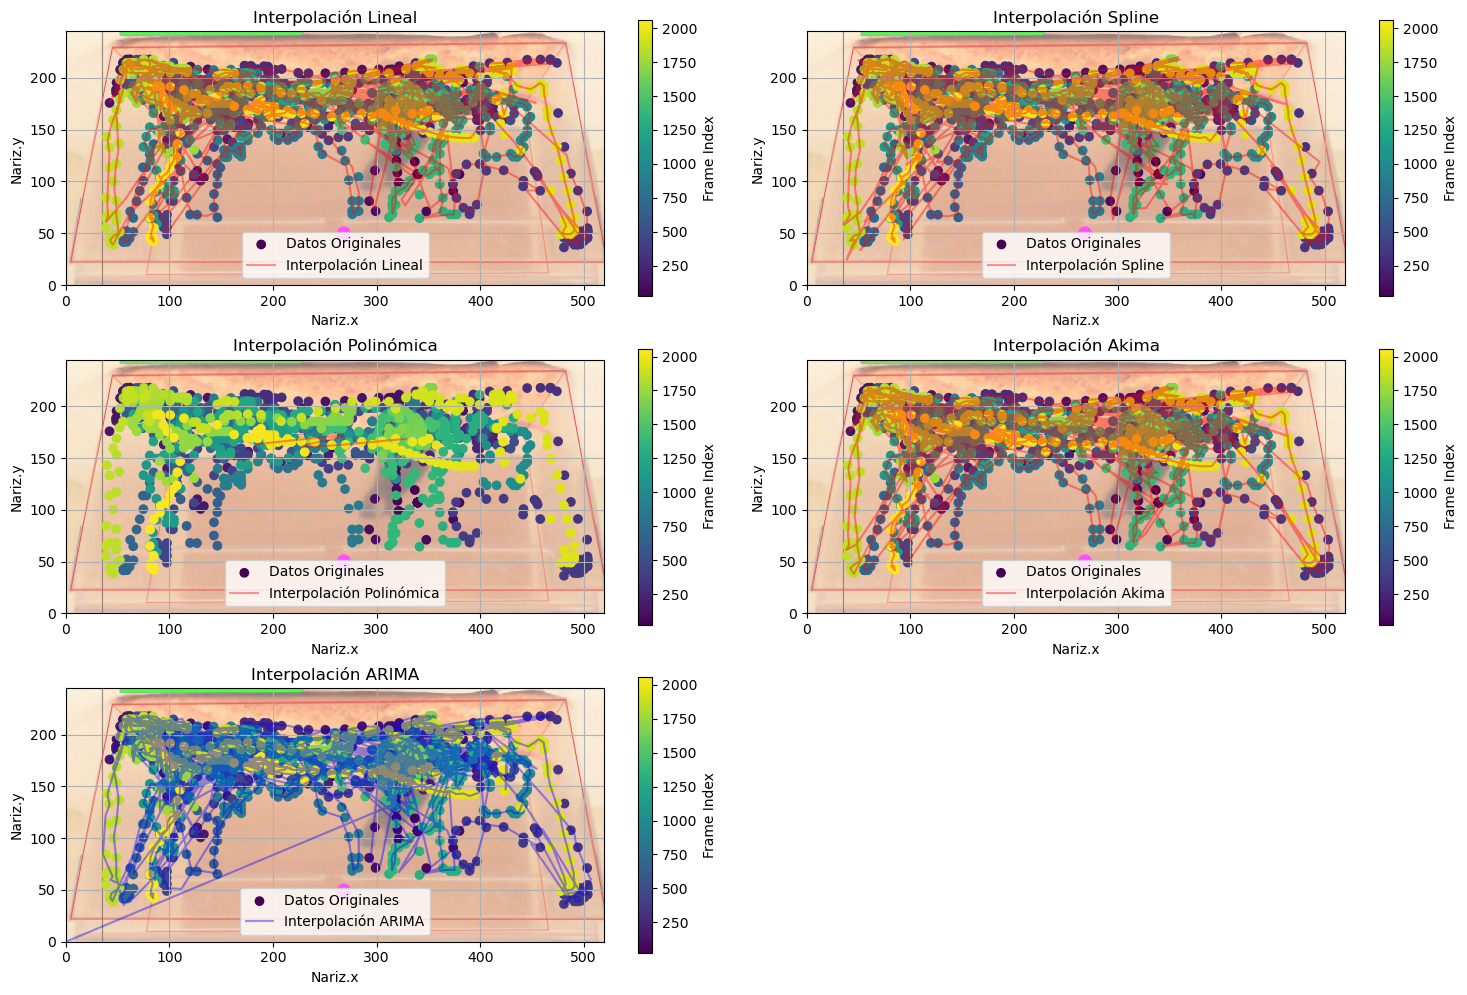

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d, UnivariateSpline, Akima1DInterpolator
from statsmodels.tsa.arima.model import ARIMA
import warnings 

# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 


# Seleccionar los primeros subset_frames puntos
subset_frames = 2000
df_subset = df.head(subset_frames)
time = df_subset['frame_idx'].values
nariz_x = df_subset['Nariz.x'].values
nariz_y = df_subset['Nariz.y'].values

# Filtrar los valores no finitos
valid_indices = np.isfinite(nariz_x) & np.isfinite(nariz_y)
time_valid = time[valid_indices]
nariz_x_valid = nariz_x[valid_indices]
nariz_y_valid = nariz_y[valid_indices]

# Crear el colormap para el frame
norm = Normalize(vmin=time_valid.min(), vmax=time_valid.max())
cmap = cm.get_cmap('magma')

# Función para aplicar diferentes métodos de interpolación y graficar en un plano XY
def plot_interpolation_xy(time, nariz_x, nariz_y):
    plt.figure(figsize=(15, 10))
    
    # Interpolación lineal
    f_linear_x = interp1d(time, nariz_x, kind='linear', fill_value='extrapolate')
    f_linear_y = interp1d(time, nariz_y, kind='linear', fill_value='extrapolate')
    time_new = np.linspace(time.min(), time.max(), subset_frames)
    nariz_x_interp_linear = f_linear_x(time_new)
    nariz_y_interp_linear = f_linear_y(time_new)
    plt.subplot(3, 2, 1)
    plt.imshow(img, alpha=0.7)
    plt.scatter(nariz_x, nariz_y, c=time, cmap='viridis', norm=norm, label='Datos Originales')
    plt.plot(nariz_x_interp_linear, nariz_y_interp_linear, '-', color='red', label='Interpolación Lineal', alpha=0.4)
    plt.xlabel('Nariz.x')
    plt.ylabel('Nariz.y')
    plt.ylim(0,245)
    plt.xlim(0,520)
    plt.title('Interpolación Lineal')
    plt.colorbar(label='Frame Index')
    plt.legend()
    plt.grid(True)
    
    # Interpolación Spline
    f_spline_x = UnivariateSpline(time, nariz_x, s=0)
    f_spline_y = UnivariateSpline(time, nariz_y, s=0)
    nariz_x_interp_spline = f_spline_x(time_new)
    nariz_y_interp_spline = f_spline_y(time_new)
    plt.subplot(3, 2, 2)
    plt.imshow(img, alpha=0.7)
    plt.scatter(nariz_x, nariz_y, c=time, cmap='viridis', norm=norm, label='Datos Originales')
    plt.plot(nariz_x_interp_spline, nariz_y_interp_spline, '-', color='red', label='Interpolación Spline', alpha=0.4)
    plt.xlabel('Nariz.x')
    plt.ylabel('Nariz.y')
    plt.ylim(0,245)
    plt.xlim(0,520)
    plt.title('Interpolación Spline')
    plt.colorbar(label='Frame Index')
    plt.legend()
    plt.grid(True)
    
    # Interpolación Polinómica
    degree = 3  # Grado del polinomio
    coeffs_x = np.polyfit(time, nariz_x, degree)
    poly_x = np.poly1d(coeffs_x)
    coeffs_y = np.polyfit(time, nariz_y, degree)
    poly_y = np.poly1d(coeffs_y)
    nariz_x_interp_poly = poly_x(time_new)
    nariz_y_interp_poly = poly_y(time_new)
    plt.subplot(3, 2, 3)
    plt.imshow(img, alpha=0.7)
    plt.scatter(nariz_x, nariz_y, c=time, cmap='viridis', norm=norm, label='Datos Originales')
    plt.plot(nariz_x_interp_poly, nariz_y_interp_poly, '-', color='red', label='Interpolación Polinómica', alpha=0.4)
    plt.xlabel('Nariz.x')
    plt.ylabel('Nariz.y')
    plt.ylim(0,245)
    plt.xlim(0,520)
    plt.title('Interpolación Polinómica')
    plt.colorbar(label='Frame Index')
    plt.legend()
    plt.grid(True)
    
    # Interpolación Akima
    if len(time_valid) > 1:  # Verificar si hay suficientes puntos válidos
        f_akima_x = Akima1DInterpolator(time_valid, nariz_x_valid)
        f_akima_y = Akima1DInterpolator(time_valid, nariz_y_valid)
        nariz_x_interp_akima = f_akima_x(time_new)
        nariz_y_interp_akima = f_akima_y(time_new)
        plt.subplot(3, 2, 4)
        plt.imshow(img, alpha=0.7)
        plt.scatter(nariz_x, nariz_y, c=time, cmap='viridis', norm=norm, label='Datos Originales')
        plt.plot(nariz_x_interp_akima, nariz_y_interp_akima, '-', color='red', label='Interpolación Akima', alpha=0.4)
        plt.xlabel('Nariz.x')
        plt.ylabel('Nariz.y')
        plt.ylim(0,245)
        plt.xlim(0,520)
        plt.title('Interpolación Akima')
        plt.colorbar(label='Frame Index')
        plt.legend()
        plt.grid(True)
    else:
        print("No hay suficientes datos válidos para la interpolación Akima.")
    
    # Interpolación ARIMA
    def arima_interpolation(time, values):
        model = ARIMA(values, order=(5,1,0))  # Ajusta el orden del modelo según sea necesario
        model_fit = model.fit()
        forecast = model_fit.predict(start=0, end=len(values)-1)
        return forecast

    nariz_x_interp_arima = arima_interpolation(time_valid, nariz_x_valid)
    nariz_y_interp_arima = arima_interpolation(time_valid, nariz_y_valid)
    
    # Reindexar las predicciones ARIMA
    time_arima = time_valid
    plt.subplot(3, 2, 5)
    plt.imshow(img, alpha=0.7)
    plt.scatter(nariz_x, nariz_y, c=time, cmap='viridis', norm=norm, label='Datos Originales')
    plt.plot(nariz_x_interp_arima, nariz_y_interp_arima, '-', color='blue', label='Interpolación ARIMA', alpha=0.4)
    plt.xlabel('Nariz.x')
    plt.ylabel('Nariz.y')
    plt.ylim(0,245)
    plt.xlim(0,520)
    plt.title('Interpolación ARIMA')
    plt.colorbar(label='Frame Index')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Aplicar la función
plot_interpolation_xy(time_valid, nariz_x_valid, nariz_y_valid)


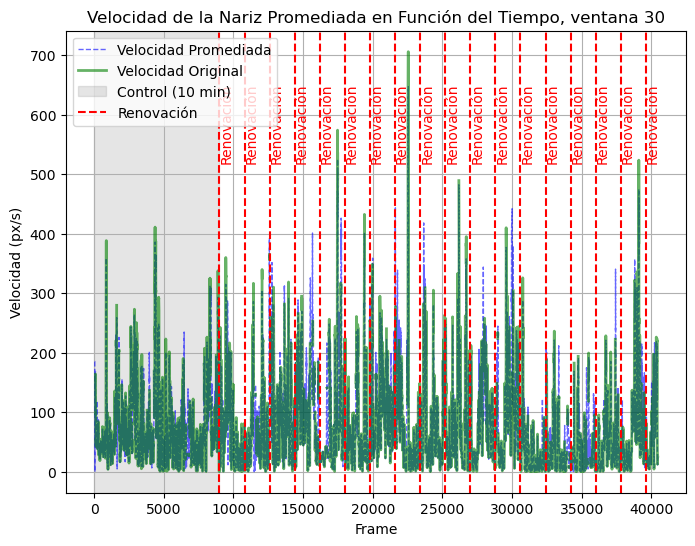

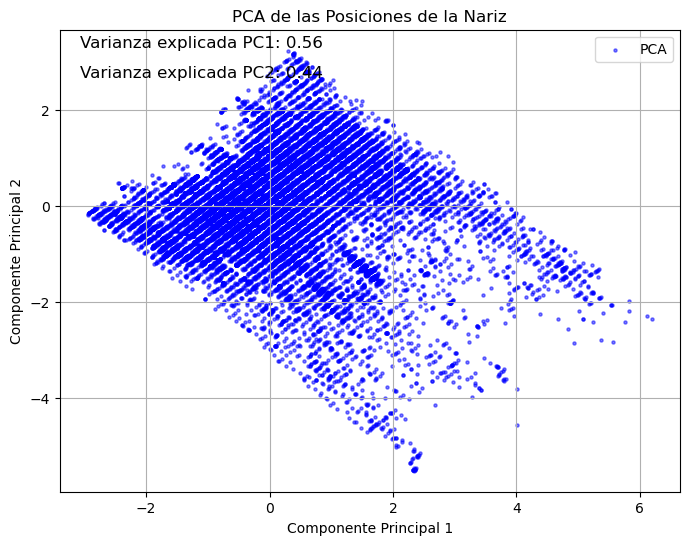

Componentes principales:
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
Varianza explicada por cada componente:
[0.56414567 0.43585433]


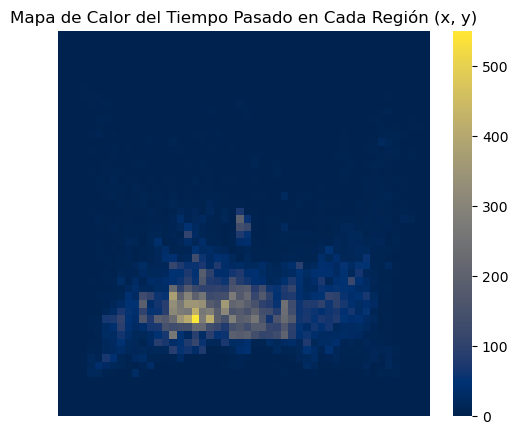

Periodo de Control - Media: 75.73, Desviación Estándar: 59.33, Mediana: 56.86
Resto del Dataset - Media: 77.13, Desviación Estándar: 75.10, Mediana: 52.42
Prueba t - Estadístico: -1.85, Valor p: 0.0650
Prueba de Mann-Whitney - Estadístico U: 151471088.00, Valor p: 0.0000


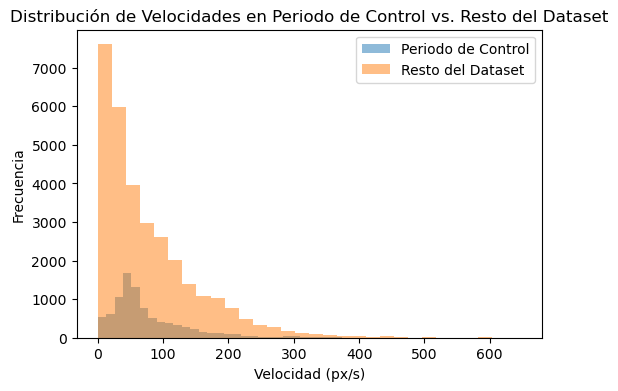

/tmp/ipykernel_1281873/3458449261.py:247: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([control_velocities_avg, rest_velocities_avg], labels=['Periodo de Control', 'Resto del Dataset'])


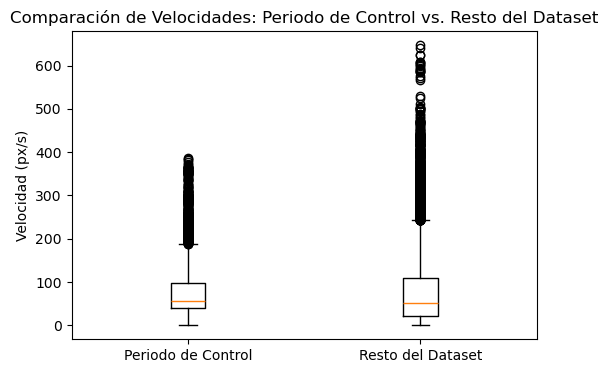

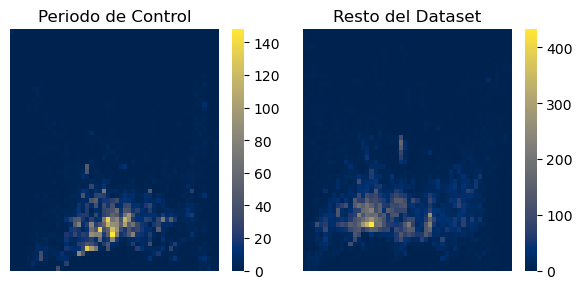

Estadísticas del Periodo de Control: {'mean_x': 248.42637489546544, 'mean_y': 174.1286354975438, 'std_x': 81.15025621000694, 'std_y': 23.213521136883465, 'mean_velocity': 79.2561473417027, 'std_velocity': 63.34259874088748}
Estadísticas del Resto del Dataset: {'mean_x': 242.03815898230567, 'mean_y': 169.45370548751225, 'std_x': 94.3549332064125, 'std_y': 23.92520819750813, 'mean_velocity': 80.91003825944844, 'std_velocity': 80.35773046151803}
Prueba t para posiciones x: TtestResult(statistic=6.3344020778551515, pvalue=2.4437368473398304e-10, df=16653.01671213633)
Prueba t para posiciones y: TtestResult(statistic=16.715081438669735, pvalue=3.728750447340155e-62, df=14951.733037999056)
Prueba t para velocidades: TtestResult(statistic=-2.0467256887747878, pvalue=0.04069938199830177, df=18169.71686950265)
Prueba KS para posiciones x: KstestResult(statistic=0.12639770578999648, pvalue=9.465406677838896e-98, statistic_location=214.0608484176617, statistic_sign=-1)
Prueba KS para posiciones y

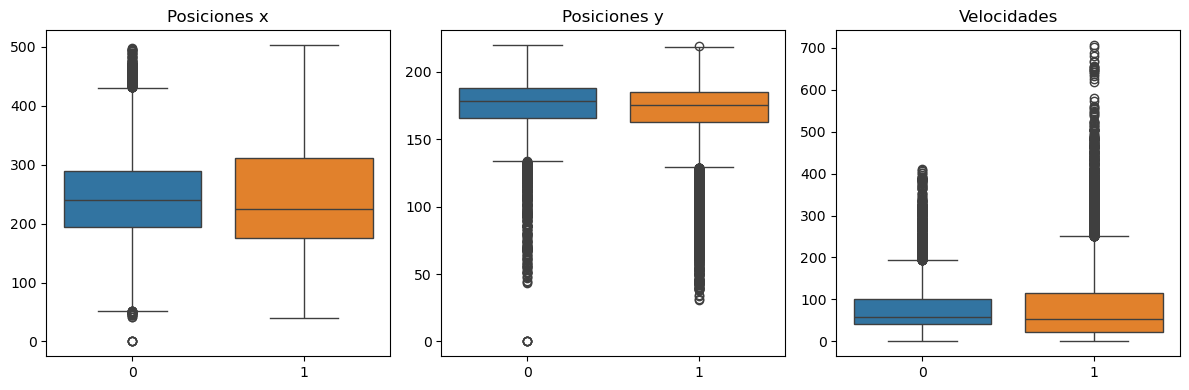

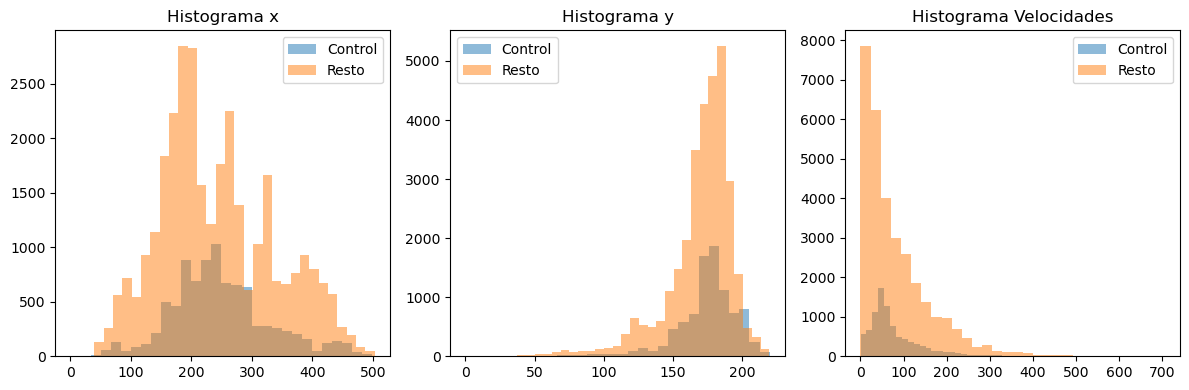

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy import stats


# Cargar y preparar los datos
file_path = 'RawData/Rela_cropped_videos.000_A-7 crop.analysis.csv'
sufix_file = 'A-7'

# define function to process csv data
def process_csv(file_path, sufix_file, interpolation_method='linear'):

    # Cargar el archivo CSV

    df = pd.read_csv(file_path)

    # Aplicar interpolación lineal, si quisieramos podriamos cambiar a Arima o cualquier otro metodo, en el caso de Arima
    # df_interpolated = df.copy()  # Iniciar con los datos originales
    # Función para aplicar ARIMA a una serie de datos
    # def apply_arima_interpolation(series):
    #     model = ARIMA(series, order=(10, 1, 0))  # Ajustar los parámetros según sea necesario
    #     model_fit = model.fit()
    #     forecast = model_fit.predict(start=0, end=len(series)-1)
    #     return forecast
    # y se aplica al dataframe de la siguiente manera
    # df_interpolated['Nariz.x'] = apply_arima_interpolation(df['Nariz.x'])
    # df_interpolated['Nariz.y'] = apply_arima_interpolation(df['Nariz.y'])
    # entonces se podria definir un condicional para seleccionar el metodo de interpolacion

    if interpolation_method == 'linear':
        df_interpolated = df.interpolate(method='linear', limit_direction='both')
    elif interpolation_method == 'arima':
        df_interpolated = df.copy()
        # Función para aplicar ARIMA a una serie de datos
        def apply_arima_interpolation(series):
            model = ARIMA(series, order=(10, 1, 0))
            model_fit = model.fit()
            forecast = model_fit.predict(start=0, end=len(series)-1)
            return forecast
        df_interpolated['Nariz.x'] = apply_arima_interpolation(df['Nariz.x'])
        df_interpolated['Nariz.y'] = apply_arima_interpolation(df['Nariz.y'])

    # Extraer posiciones de la nariz
    x_original = df['Nariz.x'].values
    y_original = df['Nariz.y'].values
    x_interpolated = df_interpolated['Nariz.x'].values
    y_interpolated = df_interpolated['Nariz.y'].values
    frames_original = df['frame_idx'].values
    frames = df_interpolated['frame_idx'].values

    # Calcular distancias entre puntos consecutivos
    distances_original = np.linalg.norm(np.diff(np.array([x_original, y_original]), axis=1), axis=0)
    distances = np.linalg.norm(np.diff(np.array([x_interpolated, y_interpolated]), axis=1), axis=0)

    # Calcular intervalos de tiempo (15 fps -> intervalo de 1/15 segundos)
    time_interval = 1 / 15
    velocities_original = distances_original / time_interval
    velocities = distances / time_interval

    # Promediar velocidades en una ventana de 15 puntos
    window_size = 30
    velocities_avg = np.convolve(velocities, np.ones(window_size)/window_size, mode='valid')
    velocities_avg_orig = np.convolve(velocities_original, np.ones(window_size)/window_size, mode='valid')

    # Ajustar los frames para que coincidan con la longitud de velocities_avg
    frames_avg = frames[(window_size-1):]  # Alinear los frames con el promedio
    frames_avg_orig = frames_original[(window_size-1):]  # Alinear los frames con el promedio

    # Comprobar y ajustar el tamaño de frames_avg para que coincida con velocities_avg
    if len(frames_avg) > len(velocities_avg):
        frames_avg = frames_avg[:len(velocities_avg)]
    elif len(frames_avg) < len(velocities_avg):
        velocities_avg = velocities_avg[:len(frames_avg)]

    # Comprobar y ajustar el tamaño de frames_avg para que coincida con velocities_avg
    if len(frames_avg_orig) > len(velocities_avg_orig):
        frames_avg_orig = frames_avg_orig[:len(velocities_avg_orig)]
    elif len(frames_avg_orig) < len(velocities_avg_orig):
        velocities_avg_orig = velocities_avg_orig[:len(frames_avg_orig)]

    # Parámetros
    fps = 15
    renewal_interval = 2 * 60  # Intervalo de renovación en segundos (2 minutos)
    initial_period = 10 * 60  # Periodo inicial sin renovación en segundos (10 minutos)
    total_exploration = int((len(frames_original) * 1/15) * 60)  # Total de tiempo en segundos

    # Calcular frames en los que ocurre cada renovación
    renewal_times = np.arange(initial_period, total_exploration, renewal_interval)
    renewal_frames = np.round(renewal_times * fps).astype(int)

    # Calcular frames para el final del periodo inicial
    initial_period_frames = int(initial_period * fps)

    # Graficar la velocidad promedio en función del tiempo
    plt.figure(figsize=(8, 6))
    plt.plot(frames_avg, velocities_avg, label='Velocidad Promediada', color='blue', alpha=0.6, linewidth=1, linestyle='--')
    plt.plot(frames_avg_orig, velocities_avg_orig, label='Velocidad Original', color='green', alpha=0.6, linewidth=2)

    # Añadir región sombreada para el periodo de control
    plt.axvspan(0, initial_period_frames, color='grey', alpha=0.2, label='Control (10 min)')

    # Añadir líneas verticales y etiquetas para los intervalos de renovación
    for renewal in renewal_frames:
        if renewal < len(frames_avg):  # Asegurar que el frame esté dentro del rango
            plt.axvline(x=renewal, color='red', linestyle='--', label='Renovación' if renewal == renewal_frames[0] else "")
            plt.text(renewal, max(velocities_avg) * 0.8, 'Renovación', rotation=90, color='red', verticalalignment='bottom')

    # Etiquetas y leyenda
    plt.xlabel('Frame')
    plt.ylabel('Velocidad (px/s)')
    plt.title(f'Velocidad de la Nariz Promediada en Función del Tiempo, ventana {window_size}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{sufix_file}_velocities.png')
    plt.show()

    # Hacer un análisis de PCA de las posiciones de la nariz

    # Extraer posiciones de la nariz, usaremos el dataset original
    x = df['Nariz.x'].values
    y = df['Nariz.y'].values

    # Crear un DataFrame con las posiciones de la nariz
    positions = pd.DataFrame({
        'x': x,
        'y': y
    })

    # Eliminar filas con valores NaN, porque el PCA no admite NaN
    positions_clean = positions.dropna()

    # Escalar los datos, todo pasa de 0 a 1
    scaler = StandardScaler()
    positions_scaled = scaler.fit_transform(positions_clean)

    # Aplicar PCA, uso dos componentes, porque es un espacio 2D. En realidad se debenrían usar otros parámetros como distancias específicas y velocidades y ángulos
    pca = PCA(n_components=2)
    positions_pca = pca.fit_transform(positions_scaled)

    # Obtener las varianzas explicadas
    explained_variance_ratio = pca.explained_variance_ratio_

    # Graficar los resultados del PCA
    plt.figure(figsize=(8, 6))
    plt.scatter(positions_pca[:, 0], positions_pca[:, 1], c='blue', alpha=0.5, label='PCA', s=5)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.title('PCA de las Posiciones de la Nariz')
    plt.legend()
    plt.grid(True)

    # Mostrar la proporción de varianza explicada por cada componente
    plt.figtext(0.15, 0.85, f'Varianza explicada PC1: {explained_variance_ratio[0]:.2f}', fontsize=12, color='black')
    plt.figtext(0.15, 0.80, f'Varianza explicada PC2: {explained_variance_ratio[1]:.2f}', fontsize=12, color='black')
    plt.savefig(f'{sufix_file}_pca.png')
    plt.show()

    # Mostrar las componentes principales
    print("Componentes principales:")
    print(pca.components_)
    print("Varianza explicada por cada componente:")
    print(explained_variance_ratio)

    # crear un mapa de calor de las posiciones de la nariz. en este caso voy a usar el dataset interpolado
    # Definir el tamaño de la cuadrícula
    grid_size = 50  # Número de divisiones en cada dirección, es arbitrario, se puede cambiar hasta que adquiera un valor agradable visualmente
    # los mínimos y los máximos de las posiciones podrian definirse estaticamente o dependiendo de los rangos verdaderos de exploración, en este acaso se usan los valores máximos y mínimos de las posiciones interpoladas
    # x_min, x_max = x_interpolated.min(), x_interpolated.max()
    # y_min, y_max = y_interpolated.min(), y_interpolated.max()

    # en cambio, si se quisiera usar los valores maximos y minimos del tamaño real del video, se podria hacer de la siguiente manera
    x_min, x_max = 0, 520
    y_min, y_max = 0, 244

    # Crear una cuadrícula
    x_edges = np.linspace(x_min, x_max, grid_size + 1)
    y_edges = np.linspace(y_min, y_max, grid_size + 1)

    # Contar el número de frames en cada celda
    hist, xedges, yedges = np.histogram2d(x_interpolated, y_interpolated, bins=[x_edges, y_edges])

    # Crear un DataFrame para el mapa de calor
    heatmap_data = pd.DataFrame(hist.T, index=y_edges[:-1], columns=x_edges[:-1])

    # Graficar el mapa de calor
    plt.figure(figsize=(6, 5))
    sns.heatmap(heatmap_data, cmap='cividis', annot=False, fmt='.0f')
    plt.axis('off')
    plt.xlabel('Posición en x')
    plt.ylabel('Posición en y')
    plt.title('Mapa de Calor del Tiempo Pasado en Cada Región (x, y)')
    plt.savefig(f'{sufix_file}_heatmap.png')
    plt.show()

    # Definir el intervalo de control
    control_end_frame = initial_period_frames

    # Extraer datos del periodo de control
    control_frames = frames_avg[:control_end_frame]
    control_velocities_avg = velocities_avg[:control_end_frame]

    # Extraer datos del resto del dataset
    rest_frames = frames_avg[control_end_frame:]
    rest_velocities_avg = velocities_avg[control_end_frame:]

    # Estadísticas para el periodo de control
    mean_control = np.mean(control_velocities_avg)
    std_control = np.std(control_velocities_avg)
    median_control = np.median(control_velocities_avg)

    # Estadísticas para el resto del dataset
    mean_rest = np.mean(rest_velocities_avg)
    std_rest = np.std(rest_velocities_avg)
    median_rest = np.median(rest_velocities_avg)

    print(f"Periodo de Control - Media: {mean_control:.2f}, Desviación Estándar: {std_control:.2f}, Mediana: {median_control:.2f}")
    print(f"Resto del Dataset - Media: {mean_rest:.2f}, Desviación Estándar: {std_rest:.2f}, Mediana: {median_rest:.2f}")


    # Prueba t de Student
    t_stat, p_value = stats.ttest_ind(control_velocities_avg, rest_velocities_avg, equal_var=False)

    # Alternativa no paramétrica
    u_stat, p_value_mannwhitney = stats.mannwhitneyu(control_velocities_avg, rest_velocities_avg)

    print(f"Prueba t - Estadístico: {t_stat:.2f}, Valor p: {p_value:.4f}")
    print(f"Prueba de Mann-Whitney - Estadístico U: {u_stat:.2f}, Valor p: {p_value_mannwhitney:.4f}")


    plt.figure(figsize=(6, 4))
    # Histograma
    plt.hist(control_velocities_avg, bins=30, alpha=0.5, label='Periodo de Control')
    plt.hist(rest_velocities_avg, bins=30, alpha=0.5, label='Resto del Dataset')
    plt.xlabel('Velocidad (px/s)')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Velocidades en Periodo de Control vs. Resto del Dataset')
    plt.legend()
    plt.savefig(f'{sufix_file}_histogram.png')
    plt.show()

    # Boxplot
    plt.figure(figsize=(6, 4))
    plt.boxplot([control_velocities_avg, rest_velocities_avg], labels=['Periodo de Control', 'Resto del Dataset'])
    plt.ylabel('Velocidad (px/s)')
    plt.title('Comparación de Velocidades: Periodo de Control vs. Resto del Dataset')
    plt.savefig(f'{sufix_file}_boxplot.png')
    plt.show()

    x_control = x_interpolated[:control_end_frame]
    y_control = y_interpolated[:control_end_frame]
    x_rest = x_interpolated[control_end_frame:]
    y_rest = y_interpolated[control_end_frame:]

    # Definir el tamaño de la cuadrícula
    grid_size = 50  # Número de divisiones en cada dirección
    x_min, x_max = x_control.min(), x_control.max()
    y_min, y_max = y_control.min(), y_control.max()

    # Crear una cuadrícula
    x_edges = np.linspace(x_min, x_max, grid_size + 1)
    y_edges = np.linspace(y_min, y_max, grid_size + 1)

    # Contar el número de frames en cada celda para el periodo de control
    hist_control, xedges, yedges = np.histogram2d(x_control, y_control, bins=[x_edges, y_edges])

    # Crear un DataFrame para el mapa de calor del periodo de control
    heatmap_data_control = pd.DataFrame(hist_control.T, index=y_edges[:-1], columns=x_edges[:-1])

    # Graficar el mapa de calor del periodo de control
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    sns.heatmap(heatmap_data_control, cmap='cividis', annot=False, fmt='.0f')
    plt.axis('off')
    plt.xlabel('Posición en x')
    plt.ylabel('Posición en y')
    plt.title('Periodo de Control')

    # Definir el tamaño de la cuadrícula
    x_min_rest, x_max_rest = x_rest.min(), x_rest.max()
    y_min_rest, y_max_rest = y_rest.min(), y_rest.max()

    # Crear una cuadrícula
    x_edges_rest = np.linspace(x_min_rest, x_max_rest, grid_size + 1)
    y_edges_rest = np.linspace(y_min_rest, y_max_rest, grid_size + 1)

    # Contar el número de frames en cada celda para el resto del dataset
    hist_rest, xedges_rest, yedges_rest = np.histogram2d(x_rest, y_rest, bins=[x_edges_rest, y_edges_rest])

    # Crear un DataFrame para el mapa de calor del resto del dataset
    heatmap_data_rest = pd.DataFrame(hist_rest.T, index=y_edges_rest[:-1], columns=x_edges_rest[:-1])

    # Graficar el mapa de calor del resto del dataset
    plt.subplot(1, 2, 2)
    sns.heatmap(heatmap_data_rest, cmap='cividis', annot=False, fmt='.0f')
    plt.axis('off')
    plt.xlabel('Posición en x')
    plt.ylabel('Posición en y')
    plt.title('Resto del Dataset')

    # Mostrar la gráfica
    plt.tight_layout()
    plt.savefig(f'{sufix_file}_heatmap_control_experiment.png')
    plt.show()

  
    # Estadísticas descriptivas
    control_stats = {
        'mean_x': np.mean(x_control),
        'mean_y': np.mean(y_control),
        'std_x': np.std(x_control),
        'std_y': np.std(y_control),
        'mean_velocity': np.mean(velocities_control),
        'std_velocity': np.std(velocities_control)
    }

    rest_stats = {
        'mean_x': np.mean(x_rest),
        'mean_y': np.mean(y_rest),
        'std_x': np.std(x_rest),
        'std_y': np.std(y_rest),
        'mean_velocity': np.mean(velocities_rest),
        'std_velocity': np.std(velocities_rest)
    }

    print("Estadísticas del Periodo de Control:", control_stats)
    print("Estadísticas del Resto del Dataset:", rest_stats)

    from scipy.stats import ttest_ind

    # Pruebas t para la comparación de medias
    ttest_x = ttest_ind(x_control, x_rest, equal_var=False)
    ttest_y = ttest_ind(y_control, y_rest, equal_var=False)
    ttest_velocity = ttest_ind(velocities_control, velocities_rest, equal_var=False)

    print("Prueba t para posiciones x:", ttest_x)
    print("Prueba t para posiciones y:", ttest_y)
    print("Prueba t para velocidades:", ttest_velocity)

    from scipy.stats import ks_2samp

    # Prueba KS para distribuciones
    ks_x = ks_2samp(x_control, x_rest)
    ks_y = ks_2samp(y_control, y_rest)
    ks_velocity = ks_2samp(velocities_control, velocities_rest)

    print("Prueba KS para posiciones x:", ks_x)
    print("Prueba KS para posiciones y:", ks_y)
    print("Prueba KS para velocidades:", ks_velocity)

    from scipy.stats import f_oneway

    # ANOVA para comparar más de dos grupos
    anova_x = f_oneway(x_control, x_rest)
    anova_y = f_oneway(y_control, y_rest)
    anova_velocity = f_oneway(velocities_control, velocities_rest)

    print("ANOVA para posiciones x:", anova_x)
    print("ANOVA para posiciones y:", anova_y)
    print("ANOVA para velocidades:", anova_velocity)

    # Boxplots
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    sns.boxplot(data=[x_control, x_rest])
    plt.title('Posiciones x')

    plt.subplot(1, 3, 2)
    sns.boxplot(data=[y_control, y_rest])
    plt.title('Posiciones y')

    plt.subplot(1, 3, 3)
    sns.boxplot(data=[velocities_control, velocities_rest])
    plt.title('Velocidades')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.hist(x_control, bins=30, alpha=0.5, label='Control')
    plt.hist(x_rest, bins=30, alpha=0.5, label='Resto')
    plt.title('Histograma x')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.hist(y_control, bins=30, alpha=0.5, label='Control')
    plt.hist(y_rest, bins=30, alpha=0.5, label='Resto')
    plt.title('Histograma y')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.hist(velocities_control, bins=30, alpha=0.5, label='Control')
    plt.hist(velocities_rest, bins=30, alpha=0.5, label='Resto')
    plt.title('Histograma Velocidades')
    plt.legend()

    plt.tight_layout()
    plt.show()

process_csv(file_path, sufix_file, interpolation_method='arima')


In [6]:
import cv2
import pandas as pd

# Cargar el archivo CSV
df = pd.read_csv(file_path)

# Cargar el video
video_path = 'RawData/A-7 crop.mp4'
cap = cv2.VideoCapture(video_path)

# Obtener dimensiones del video
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Crear el writer para guardar el video
output_path = 'RawData/A-7 skeleton.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Definir las conexiones en una lista de tuplas (punto A, punto B)
connections = [
    ("Nariz", "Frente"),
    ("Frente", "Lomo"),
    ("Lomo", "Base"),
    ("Nariz", "O_D"),
    ("Nariz", "O_I"),
    ("O_D", "O_I"),
    ("O_D", "Lomo"),
    ("O_I", "Lomo"),
    ("Nariz", "Frente"),
    ("Frente", "Base")
]

# Mapeo de nombres de keypoints a columnas
keypoints_columns = {
    "O_D": ('O_D.x', 'O_D.y'),
    "O_I": ('O_I.x', 'O_I.y'),
    "Nariz": ('Nariz.x', 'Nariz.y'),
    "Lomo": ('Lomo.x', 'Lomo.y'),
    "Base": ('Base.x', 'Base.y'),
    "Frente": ('Frente.x', 'Frente.y')
}

frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Filtrar los datos del frame actual
    if frame_idx in df['frame_idx'].values:
        frame_data = df[df['frame_idx'] == frame_idx].iloc[0]

        # Dibujar los puntos clave
        keypoints = {}
        for key, (x_col, y_col) in keypoints_columns.items():
            x = frame_data[x_col]
            y = frame_data[y_col]
            if not np.isnan(x) and not np.isnan(y):
                keypoints[key] = (int(x), int(y))
                cv2.circle(frame, (int(x), int(y)), 5, (0, 255, 0), -1)  # Dibuja los puntos como círculos verdes

        # Dibujar las conexiones (esqueleto)
        for point_a, point_b in connections:
            if point_a in keypoints and point_b in keypoints:
                cv2.line(frame, keypoints[point_a], keypoints[point_b], (0, 0, 255), 2)  # Líneas rojas

    # Escribir el frame con el esqueleto en el video de salida
    out.write(frame)

    # Incrementar el índice del frame
    frame_idx += 1

# Liberar recursos
cap.release()
out.release()
cv2.destroyAllWindows()

In [11]:
import pandas as pd
import cv2
import numpy as np
import time

# Cargar el archivo CSV
file_path = 'RawData/Rela_cropped_videos.007_H-1 crop.analysis.csv'
video_path = 'RawData/H-1 crop.mp4'
output_path = 'RawData/H-1 linear trail.mp4'

start_time = time.time()

df = pd.read_csv(file_path)

# Aplicar interpolación lineal
df_interpolated = df.interpolate(method='linear', limit_direction='both')

# Lista de puntos clave que quieres graficar
puntos_a_graficar = ["Nariz", "Lomo", "Base"]  # Puedes modificar esta lista

# Cargar el video
cap = cv2.VideoCapture(video_path)

# Obtener dimensiones del video
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Crear el writer para guardar el video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Definir las conexiones en una lista de tuplas (punto A, punto B)
connections = [
    ("Nariz", "Frente"),
    ("Frente", "Lomo"),
    ("Lomo", "Base"),
    ("Nariz", "O_D"),
    ("Nariz", "O_I"),
    ("O_D", "O_I"),
    ("O_D", "Lomo"),
    ("O_I", "Lomo"),
    ("Nariz", "Frente"),
    ("Frente", "Base"),
    ("Nariz", "Lomo")
]

# Mapeo de nombres de keypoints a columnas
keypoints_columns = {
    "O_D": ('O_D.x', 'O_D.y'),
    "O_I": ('O_I.x', 'O_I.y'),
    "Nariz": ('Nariz.x', 'Nariz.y'),
    "Lomo": ('Lomo.x', 'Lomo.y'),
    "Base": ('Base.x', 'Base.y'),
    "Frente": ('Frente.x', 'Frente.y')
}

# Coordenadas del hisopo (punto fijo)
hisopo_position = (270, 50)  # Reemplaza con las coordenadas reales del hisopo en tu video

# Para almacenar la trayectoria de la "Nariz"
trail_length = 10  # Puedes ajustar el número de frames que muestra el trail
trail_points = []

frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Calcular el tiempo transcurrido en segundos
    elapsed_time = frame_idx / fps

    # Formatear el tiempo como minutos:segundos:milisegundos
    time_text = f'{int(elapsed_time // 60):02}:{int(elapsed_time % 60):02}:{int((elapsed_time * 1000) % 1000):03}'

    # Colocar el temporizador en el frame, el tamaño de la fuente y el color se pueden ajustar según sea necesario, el tamaño con la variable 1 que puede tener valores de 0.5 a 2
    # Las fuentes se controlan con la variable cv2.FONT_HERSHEY_SIMPLEX. Las otras fuentes disponibles son: 
    # cv2.FONT_HERSHEY_COMPLEX, cv2.FONT_HERSHEY_DUPLEX, cv2.FONT_HERSHEY_PLAIN, cv2.FONT_HERSHEY_TRIPLEX, cv2.FONT_HERSHEY_COMPLEX_SMALL, cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, cv2.FONT_HERSHEY_SCRIPT_COMPLEX
    cv2.putText(frame, time_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA) 

    # Dibujar el hisopo como un punto fijo
    #cv2.circle(frame, hisopo_position, 3, (255, 0, 255), -1)  # Magenta para el hisopo


    # Filtrar los datos del frame actual
    if frame_idx in df['frame_idx'].values:
        frame_data_original = df[df['frame_idx'] == frame_idx].iloc[0]
        frame_data_interpolated = df_interpolated[df_interpolated['frame_idx'] == frame_idx].iloc[0]

        # Dibujar los puntos clave
        keypoints = {}
        for key in puntos_a_graficar:
            if key in keypoints_columns:
                x_col, y_col = keypoints_columns[key]
                x = frame_data_interpolated[x_col]
                y = frame_data_interpolated[y_col]

                if not np.isnan(x) and not np.isnan(y):
                    keypoints[key] = (int(x), int(y))

                    # Verificar si el valor fue interpolado
                    if np.isnan(frame_data_original[x_col]) or np.isnan(frame_data_original[y_col]):
                        # Si fue interpolado, dibujar en color diferente (rojo)
                        cv2.circle(frame, (int(x), int(y)), 2, (0, 0, 255), -1)  # Rojo para puntos interpolados
                    else:
                        # Si no fue interpolado, dibujar en el color original (verde)
                        cv2.circle(frame, (int(x), int(y)), 2, (0, 255, 0), -1)  # Verde para puntos originales


        # Agregar el punto actual de la Nariz al trail
        if "Nariz" in keypoints:
            trail_points.append(keypoints["Nariz"])

            # Mantener solo los últimos N puntos del trail
            if len(trail_points) > trail_length:
                trail_points.pop(0)

            # Ejemplo para un trail con desvanecimiento
            for i in range(1, len(trail_points)):
                alpha = i / len(trail_points)  # Cuanto más antiguo el punto, más tenue será
                color = (int(255 * (1 - alpha)), 255, 96)
                cv2.line(frame, trail_points[i-1], trail_points[i], color, 1)

            # Dibujar el vector desde el hisopo hasta la Nariz
            #cv2.line(frame, hisopo_position, keypoints["Nariz"], (0, 255, 255), 1)  # Cian para el vector

            # Calcular la distancia entre el hisopo y la Nariz
            distance = np.linalg.norm(np.array(hisopo_position) - np.array(keypoints["Nariz"]))

            # Mostrar la distancia en el frame
            distance_text = f'Distancia: {int(distance)} px'
            cv2.putText(frame, distance_text, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)


        # Dibujar las conexiones (esqueleto)
        for point_a, point_b in connections:
            if point_a in keypoints and point_b in keypoints:
                cv2.line(frame, keypoints[point_a], keypoints[point_b], (200, 200, 200), 1)  # Líneas azules
        

    # Escribir el frame con el esqueleto y el trail en el video de salida
    out.write(frame)

    # Incrementar el índice del frame
    frame_idx += 1

# Liberar recursos
cap.release()
out.release()
cv2.destroyAllWindows()

print('Tiempo total:', int(time.time() - start_time), 'segundos')

Tiempo total: 26 segundos


In [95]:
import pandas as pd
import cv2
import numpy as np
import time
from statsmodels.tsa.arima.model import ARIMA

# Configura la interpolación que deseas usar: 'linear' o 'arima'
interpolation_method = 'arima'  # Cambia a 'arima' para usar ARIMA

# Cargar el archivo CSV
file_path = 'RawData/Rela_cropped_videos.007_H-1 crop.analysis.csv'
video_path = 'RawData/H-1 crop.mp4'
output_path = 'RawData/H-1 arima trail.mp4'

start_time = time.time()

df = pd.read_csv(file_path)

# Aplicar interpolación según el método seleccionado
if interpolation_method == 'linear':
    df_interpolated = df.interpolate(method='linear', limit_direction='both')
elif interpolation_method == 'arima':
    df_interpolated = df.copy()  # Iniciar con los datos originales
    # Función para aplicar ARIMA a una serie de datos
    def apply_arima_interpolation(series):
        model = ARIMA(series, order=(10, 1, 0))  # Ajustar los parámetros según sea necesario
        model_fit = model.fit()
        forecast = model_fit.predict(start=0, end=len(series)-1)
        return forecast

    # Aplicar ARIMA a cada columna relevante
    for key in ["Nariz", "Lomo", "Base", "Frente", "O_D", "O_I"]:
        x_col = f'{key}.x'
        y_col = f'{key}.y'
        df_interpolated[x_col] = apply_arima_interpolation(df[x_col])
        df_interpolated[y_col] = apply_arima_interpolation(df[y_col])
else:
    print(f'Método de interpolación no válido: {interpolation_method}, se hara sin interpolación.')
    df_interpolated = df.copy()

# Lista de puntos clave que quieres graficar
puntos_a_graficar = ["Nariz", "Lomo", "Base"]  # Puedes modificar esta lista

print(f'Datos a plotear {file_path}')
print(f'Puntos a plotear {puntos_a_graficar}')
print(f'Video a plotear {video_path}')
print(f'Video de salida {output_path}')
print(f'Método de interpolación: {interpolation_method}')


# Cargar el video
cap = cv2.VideoCapture(video_path)

# Obtener dimensiones del video
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Crear el writer para guardar el video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Definir las conexiones en una lista de tuplas (punto A, punto B)
connections = [
    ("Nariz", "Frente"),
    ("Frente", "Lomo"),
    ("Lomo", "Base"),
    ("Nariz", "O_D"),
    ("Nariz", "O_I"),
    ("O_D", "O_I"),
    ("O_D", "Lomo"),
    ("O_I", "Lomo"),
    ("Nariz", "Frente"),
    ("Frente", "Base"),
    ("Nariz", "Lomo")
]

# Mapeo de nombres de keypoints a columnas
keypoints_columns = {
    "O_D": ('O_D.x', 'O_D.y'),
    "O_I": ('O_I.x', 'O_I.y'),
    "Nariz": ('Nariz.x', 'Nariz.y'),
    "Lomo": ('Lomo.x', 'Lomo.y'),
    "Base": ('Base.x', 'Base.y'),
    "Frente": ('Frente.x', 'Frente.y')
}

# Coordenadas del hisopo (punto fijo)
hisopo_position = (270, 50)  # Reemplaza con las coordenadas reales del hisopo en tu video

# Para almacenar la trayectoria de la "Nariz"
trail_length = 10  # Puedes ajustar el número de frames que muestra el trail
trail_points = []

frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Calcular el tiempo transcurrido en segundos
    elapsed_time = frame_idx / fps

    # Formatear el tiempo como minutos:segundos:milisegundos
    time_text = f'{int(elapsed_time // 60):02}:{int(elapsed_time % 60):02}:{int((elapsed_time * 1000) % 1000):03}'

    # Colocar el temporizador en el frame
    cv2.putText(frame, time_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)

    # Dibujar el hisopo como un punto fijo, aproximadamente
    cv2.circle(frame, (hisopo_position[0], hisopo_position[1]), 3, (0, 255, 255), -1)  # Magenta para el hisopo

    # Filtrar los datos del frame actual
    if frame_idx in df['frame_idx'].values:
        frame_data_original = df[df['frame_idx'] == frame_idx].iloc[0]
        frame_data_interpolated = df_interpolated[df_interpolated['frame_idx'] == frame_idx].iloc[0]

        # Dibujar los puntos clave
        keypoints = {}
        for key in puntos_a_graficar:
            if key in keypoints_columns:
                x_col, y_col = keypoints_columns[key]
                x = frame_data_interpolated[x_col]
                y = frame_data_interpolated[y_col]

                if not np.isnan(x) and not np.isnan(y):
                    keypoints[key] = (int(x), int(y))

                    # Verificar si el valor fue interpolado
                    if np.isnan(frame_data_original[x_col]) or np.isnan(frame_data_original[y_col]):
                        # Si fue interpolado, dibujar en color diferente (rojo)
                        cv2.circle(frame, (int(x), int(y)), 3, (0, 0, 255), -1)  # Rojo para puntos interpolados
                    else:
                        # Si no fue interpolado, dibujar en el color original (verde)
                        cv2.circle(frame, (int(x), int(y)), 3, (0, 255, 0), -1)  # Verde para puntos originales

        # Agregar el punto actual de la Nariz al trail
        if "Nariz" in keypoints:
            trail_points.append(keypoints["Nariz"])

            # Mantener solo los últimos N puntos del trail
            if len(trail_points) > trail_length:
                trail_points.pop(0)

            # Ejemplo para un trail con desvanecimiento
            for i in range(1, len(trail_points)):
                alpha = i / len(trail_points)  # Cuanto más antiguo el punto, más tenue será
                color = (int(255 * (1 - alpha)), int(255 * (1 - alpha)), 64)
                cv2.line(frame, trail_points[i-1], trail_points[i], color, 2)

            # Dibujar el vector desde el hisopo hasta la Nariz
            #cv2.line(frame, hisopo_position, keypoints["Nariz"], (0, 255, 255), 1)  # Cian para el vector

            # Calcular la distancia entre el hisopo y la Nariz
            distance = np.linalg.norm(np.array(hisopo_position) - np.array(keypoints["Nariz"]))

            # Mostrar la distancia en el frame
            distance_text = f'Distancia al hisopo: {int(distance)} px, aprox'
            cv2.putText(frame, distance_text, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1, cv2.LINE_AA)

        # Dibujar las conexiones (esqueleto)
        for point_a, point_b in connections:
            if point_a in keypoints and point_b in keypoints:
                cv2.line(frame, keypoints[point_a], keypoints[point_b], (200, 200, 200), 2)  # Líneas azules

    # Escribir el frame con el esqueleto y el trail en el video de salida
    out.write(frame)

    # Incrementar el índice del frame
    frame_idx += 1

# Liberar recursos
cap.release()
out.release()
cv2.destroyAllWindows()

print('Tiempo total:', int(time.time() - start_time), 'segundos')


Datos a plotear RawData/Rela_cropped_videos.007_H-1 crop.analysis.csv
Puntos a plotear ['Nariz', 'Lomo', 'Base']
Video a plotear RawData/H-1 crop.mp4
Video de salida RawData/H-1 arima trail.mp4
Método de interpolación: arima
Tiempo total: 27 segundos


In [106]:
import pandas as pd
import cv2
import numpy as np
import time
from statsmodels.tsa.arima.model import ARIMA

def apply_arima_interpolation(series):
    # Elimina NaNs temporales para ajustar el modelo ARIMA
    series_temp = series.copy()
    series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
    
    # Ajustar el modelo ARIMA a la serie completa
    model = ARIMA(series_temp, order=(10, 1, 1))  # Ajusta los parámetros (p,d,q) según sea necesario
    model_fit = model.fit()
    forecast = model_fit.predict(start=0, end=len(series)-1, dynamic=False)
    
    # Rellenar los valores NaN con las predicciones
    return forecast

def process_video(interpolation_method, file_path, video_path, output_path, puntos_a_graficar, hisopo_position=(270, 50), trail_length=10):
    start_time = time.time()

    df = pd.read_csv(file_path)

    # Aplicar interpolación según el método seleccionado
    if interpolation_method == 'linear':
        df_interpolated = df.interpolate(method='linear', limit_direction='both')
    elif interpolation_method == 'arima':
        df_interpolated = df.copy()  # Iniciar con los datos originales

        # Aplicar ARIMA a cada columna relevante
        for key in ["Nariz", "Lomo", "Base", "Frente", "O_D", "O_I"]:
            x_col = f'{key}.x'
            y_col = f'{key}.y'
            
            # Aplicar ARIMA a las columnas x y y
            if x_col in df.columns:
                df_interpolated[x_col] = apply_arima_interpolation(df[x_col])
            if y_col in df.columns:
                df_interpolated[y_col] = apply_arima_interpolation(df[y_col])
    else:
        print(f'Método de interpolación no válido: {interpolation_method}. Se hará sin interpolación.')
        df_interpolated = df.copy()

    print(f'Datos a plotear {file_path}')
    print(f'Puntos a plotear {puntos_a_graficar}')
    print(f'Video a plotear {video_path}')
    print(f'Video de salida {output_path}')
    print(f'Método de interpolación: {interpolation_method}')

    # Cargar el video
    cap = cv2.VideoCapture(video_path)

    # Obtener dimensiones del video
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Crear el writer para guardar el video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Definir las conexiones en una lista de tuplas (punto A, punto B)
    connections = [
        ("Nariz", "Frente"),
        ("Frente", "Lomo"),
        ("Lomo", "Base"),
        ("Nariz", "O_D"),
        ("Nariz", "O_I"),
        ("O_D", "O_I"),
        ("O_D", "Lomo"),
        ("O_I", "Lomo"),
        ("Nariz", "Frente"),
        ("Frente", "Base"),
        ("Nariz", "Lomo")
    ]

    # Mapeo de nombres de keypoints a columnas
    keypoints_columns = {
        "O_D": ('O_D.x', 'O_D.y'),
        "O_I": ('O_I.x', 'O_I.y'),
        "Nariz": ('Nariz.x', 'Nariz.y'),
        "Lomo": ('Lomo.x', 'Lomo.y'),
        "Base": ('Base.x', 'Base.y'),
        "Frente": ('Frente.x', 'Frente.y')
    }

    # Para almacenar la trayectoria de la "Nariz"
    trail_points = []

    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Calcular el tiempo transcurrido en segundos
        elapsed_time = frame_idx / fps

        # Formatear el tiempo como minutos:segundos:milisegundos
        time_text = f'{int(elapsed_time // 60):02}:{int(elapsed_time % 60):02}:{int((elapsed_time * 1000) % 1000):03}'

        # Colocar el temporizador en el frame
        cv2.putText(frame, time_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA) 

        # Filtrar los datos del frame actual
        if frame_idx in df['frame_idx'].values:
            frame_data_original = df[df['frame_idx'] == frame_idx].iloc[0]
            frame_data_interpolated = df_interpolated[df_interpolated['frame_idx'] == frame_idx].iloc[0]

            # Dibujar los puntos clave
            keypoints = {}
            for key in puntos_a_graficar:
                if key in keypoints_columns:
                    x_col, y_col = keypoints_columns[key]
                    x = frame_data_interpolated[x_col]
                    y = frame_data_interpolated[y_col]

                    if not np.isnan(x) and not np.isnan(y):
                        keypoints[key] = (int(x), int(y))

                        # Verificar si el valor fue interpolado
                        if np.isnan(frame_data_original[x_col]) or np.isnan(frame_data_original[y_col]):
                            # Si fue interpolado, dibujar en color diferente (rojo)
                            cv2.circle(frame, (int(x), int(y)), 4, (0, 0, 255), -1)  # Rojo para puntos interpolados
                        else:
                            # Si no fue interpolado, dibujar en el color original (verde)
                            cv2.circle(frame, (int(x), int(y)), 4, (0, 255, 0), -1)  # Verde para puntos originales

            # Agregar el punto actual de la Nariz al trail
            if "Nariz" in keypoints:
                trail_points.append(keypoints["Nariz"])

                # Mantener solo los últimos N puntos del trail
                if len(trail_points) > trail_length:
                    trail_points.pop(0)

                # Ejemplo para un trail con desvanecimiento
                for i in range(1, len(trail_points)):
                    alpha = i / len(trail_points)  # Cuanto más antiguo el punto, más tenue será
                    color = (int(255 * (1 - alpha)), 96, 96)
                    cv2.line(frame, trail_points[i-1], trail_points[i], color, 1)

                # Dibujar el vector desde el hisopo hasta la Nariz
                # cv2.line(frame, hisopo_position, keypoints["Nariz"], (0, 255, 255), 1)  # Cian para el vector

                # Calcular la distancia entre el hisopo y la Nariz
                distance = np.linalg.norm(np.array(hisopo_position) - np.array(keypoints["Nariz"]))

                # Mostrar la distancia en el frame
                distance_text = f'Distancia al hisopo: {int(distance)} px, aprox'
                cv2.putText(frame, distance_text, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1, cv2.LINE_AA)
                cv2.putText(frame, "H", (hisopo_position[0], hisopo_position[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1, cv2.LINE_AA)

            # Dibujar las conexiones (esqueleto)
            for point_a, point_b in connections:
                if point_a in keypoints and point_b in keypoints:
                    cv2.line(frame, keypoints[point_a], keypoints[point_b], (200, 200, 200), 1)  # Líneas azules

        # Escribir el frame con el esqueleto y el trail en el video de salida
        out.write(frame)

        # Incrementar el índice del frame
        frame_idx += 1

    # Liberar recursos
    cap.release()
    out.release()
    cv2.destroyAllWindows()

    print('Tiempo total:', int(time.time() - start_time), 'segundos')

import os

# Define las rutas de los directorios
csv_dir = 'RawData/'  # Cambia esto a tu directorio de CSV
video_dir = 'RawData/'  # Cambia esto a tu directorio de videos
output_dir = 'RawData/Output'  # Cambia esto a tu directorio de salida
interpolation_method = 'arima'  # Cambia esto al método de interpolación deseado

# Asegúrate de que el directorio de salida exista
os.makedirs(output_dir, exist_ok=True)

# Crear el diccionario de mapeo entre los nombres de archivos CSV y videos
file_mapping = {
    'Rela_cropped_videos.000_A-7 crop.analysis.csv': 'A-7 crop.mp4',
    'Rela_cropped_videos.001_B-4 crop.analysis.csv': 'B-4 crop.mp4',
    'Rela_cropped_videos.002_C-3 crop.analysis.csv': 'C-3 crop.mp4',
    'Rela_cropped_videos.003_D-6 crop.analysis.csv': 'D-6 crop.mp4',
    'Rela_cropped_videos.004_E-5 crop.analysis.csv': 'E-5 crop.mp4',
    'Rela_cropped_videos.005_F-8 crop.analysis.csv': 'F-8 crop.mp4',
    'Rela_cropped_videos.006_G-2 crop.analysis.csv': 'G-2 crop.mp4',
    'Rela_cropped_videos.007_H-1 crop.analysis.csv': 'H-1 crop.mp4'
}

# Define los puntos a graficar
puntos_a_graficar = ["Nariz", "Lomo", "Base"]  # Puedes ajustar esto según sea necesario

# Itera sobre el diccionario para procesar los archivos
for csv_file, video_file in file_mapping.items():
    csv_path = os.path.join(csv_dir, csv_file)
    video_path = os.path.join(video_dir, video_file)
    output_path = os.path.join(output_dir, f'{os.path.splitext(csv_file)[0]}_{interpolation_method}_trail_10-2-1.mp4')
    
    # Llama a la función process_video para cada par de archivos CSV y video
    print(f'Procesando {csv_file} y {video_file}...')
    process_video(
        interpolation_method=interpolation_method,
        file_path=csv_path,
        video_path=video_path,
        output_path=output_path,
        puntos_a_graficar=puntos_a_graficar
    )
    print(f'Video de salida guardado en {output_path}')

/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() inst

Datos a plotear RawData/Rela_cropped_videos.000_A-7 crop.analysis.csv
Puntos a plotear ['Nariz', 'Lomo', 'Base']
Video a plotear RawData/A-7 crop.mp4
Video de salida RawData/Output/Rela_cropped_videos.000_A-7 crop.analysis_arima_trail_10-2-1.mp4
Método de interpolación: arima
Tiempo total: 181 segundos


/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() inst

Datos a plotear RawData/Rela_cropped_videos.001_B-4 crop.analysis.csv
Puntos a plotear ['Nariz', 'Lomo', 'Base']
Video a plotear RawData/B-4 crop.mp4
Video de salida RawData/Output/Rela_cropped_videos.001_B-4 crop.analysis_arima_trail_10-2-1.mp4
Método de interpolación: arima
Tiempo total: 355 segundos


/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/home/juan/miniforge3/envs/ML/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.inte

Datos a plotear RawData/Rela_cropped_videos.002_C-3 crop.analysis.csv
Puntos a plotear ['Nariz', 'Lomo', 'Base']
Video a plotear RawData/C-3 crop.mp4
Video de salida RawData/Output/Rela_cropped_videos.002_C-3 crop.analysis_arima_trail_10-2-1.mp4
Método de interpolación: arima
Tiempo total: 391 segundos


/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() inst

Datos a plotear RawData/Rela_cropped_videos.003_D-6 crop.analysis.csv
Puntos a plotear ['Nariz', 'Lomo', 'Base']
Video a plotear RawData/D-6 crop.mp4
Video de salida RawData/Output/Rela_cropped_videos.003_D-6 crop.analysis_arima_trail_10-2-1.mp4
Método de interpolación: arima
Tiempo total: 386 segundos


/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/home/juan/miniforge3/envs/ML/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.inte

Datos a plotear RawData/Rela_cropped_videos.004_E-5 crop.analysis.csv
Puntos a plotear ['Nariz', 'Lomo', 'Base']
Video a plotear RawData/E-5 crop.mp4
Video de salida RawData/Output/Rela_cropped_videos.004_E-5 crop.analysis_arima_trail_10-2-1.mp4
Método de interpolación: arima
Tiempo total: 421 segundos


/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() inst

Datos a plotear RawData/Rela_cropped_videos.005_F-8 crop.analysis.csv
Puntos a plotear ['Nariz', 'Lomo', 'Base']
Video a plotear RawData/F-8 crop.mp4
Video de salida RawData/Output/Rela_cropped_videos.005_F-8 crop.analysis_arima_trail_10-2-1.mp4
Método de interpolación: arima
Tiempo total: 407 segundos


/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/home/juan/miniforge3/envs/ML/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.inte

Datos a plotear RawData/Rela_cropped_videos.006_G-2 crop.analysis.csv
Puntos a plotear ['Nariz', 'Lomo', 'Base']
Video a plotear RawData/G-2 crop.mp4
Video de salida RawData/Output/Rela_cropped_videos.006_G-2 crop.analysis_arima_trail_10-2-1.mp4
Método de interpolación: arima
Tiempo total: 399 segundos


/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_temp = series_temp.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_1281873/3856297219.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() inst

Datos a plotear RawData/Rela_cropped_videos.007_H-1 crop.analysis.csv
Puntos a plotear ['Nariz', 'Lomo', 'Base']
Video a plotear RawData/H-1 crop.mp4
Video de salida RawData/Output/Rela_cropped_videos.007_H-1 crop.analysis_arima_trail_10-2-1.mp4
Método de interpolación: arima
Tiempo total: 223 segundos
